In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.metrics import accuracy_score

class IndicSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Load the dataset from a CSV file
df = pd.read_csv('dataset_test.csv')

# Extract the reviews and labels
reviews = df['INDIC REVIEW'].tolist()  # Modify this line based on the actual column name for reviews
labels = df['LABEL'].tolist()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the dataset into train and test sets
reviews_train, reviews_test, labels_train, labels_test = train_test_split(reviews, labels_encoded, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

encodings_train = tokenizer(reviews_train, truncation=True, padding=True)
encodings_test = tokenizer(reviews_test, truncation=True, padding=True)

dataset_train = IndicSentimentDataset(encodings_train, labels_train)
dataset_test = IndicSentimentDataset(encodings_test, labels_test)

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(label_encoder.classes_))

def train(model, dataloader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)
            predictions.extend(predicted_labels.cpu().numpy().tolist())
            true_labels.extend(labels.cpu().numpy().tolist())
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16
epochs = 5
learning_rate = 2e-5
warmup_steps = 100

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

optimizer = AdamW(model.parameters(), lr=learning_rate)
num_training_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    avg_train_loss = train(model, train_dataloader, optimizer, device, scheduler)
    accuracy = evaluate(model, test_dataloader, device)
    print(f"Train Loss: {avg_train_loss:.2f}")
    print(f"Test Accuracy: {accuracy:.2f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\mrlazy\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5
Train Loss: 0.92
Test Accuracy: 0.68
Epoch 2/5
Train Loss: 0.50
Test Accuracy: 0.73
Epoch 3/5
Train Loss: 0.33
Test Accuracy: 0.85
Epoch 4/5
Train Loss: 0.20
Test Accuracy: 0.89
Epoch 5/5
Train Loss: 0.11
Test Accuracy: 0.86


In [10]:
print(f"Test Accuracy: {accuracy * 100:.2f}")

Test Accuracy: 86.50


In [11]:
# Save the model
model_path = "model.h5"
torch.save(model.state_dict(), model_path)

In [33]:
def predict_with_label(model, tokenizer, text, label_encoder, device):
    encoded_text = tokenizer(text, truncation=True, padding=True, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(**encoded_text)
        logits = output.logits
        predicted_label_id = torch.argmax(logits, dim=1).item()
        predicted_label = label_encoder.inverse_transform([predicted_label_id])[0]
        return predicted_label

In [43]:
# Test predictions on new data
new_text = "ನೀವು ಅಪ್ಲಿಕೇಶನ್‌ನೊಂದಿಗೆ ಏನನ್ನು ಹಂಚಿಕೊಳ್ಳಲು ಬಯಸುತ್ತೀರಿ ಎಂಬುದನ್ನು ನಿಯಂತ್ರಿಸಲು ಇದು ನಿಮಗೆ ಅನುಮತಿಸುತ್ತದೆ. ಮತ್ತು ಅವರು ನಿಜವಾಗಿಯೂ ನಿಮ್ಮ ಖಾಸಗಿ ಜಾಗದಲ್ಲಿ ನಿಕ್ಕ್ ಮಾಡುವುದಿಲ್ಲ."
predicted_label = predict_with_label(model, tokenizer, new_text, label_encoder, device)
print("Predicted Label:", predicted_label)

Predicted Label: Positive


In [16]:
# def predict(model, tokenizer, text, device):
#     encoded_text = tokenizer(text, truncation=True, padding=True, return_tensors='pt').to(device)
#     with torch.no_grad():
#         output = model(**encoded_text)
#         logits = output.logits
#         predicted_label = torch.argmax(logits, dim=1).item()
#         return predicted_label

In [31]:
# # Test predictions on new data
# new_text = "ಈ ಮೊಬೈಲ್ ಫೋನ್‌ನ ಬ್ಯಾಟರಿ ತುಂಬಾ ಚೆನ್ನಾಗಿದೆ"
# predicted_label = predict(model, tokenizer, new_text, device)
# if predicted_label ==1:
#     print("Positive")
# else:
#     print("Negative")
# print("Predicted Label:", predicted_label)

Positive
Predicted Label: 1


In [19]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Print all labels
print("All labels available:")
for label in label_encoder.classes_:
    print(label)


All labels available:
Negative
Positive
nan


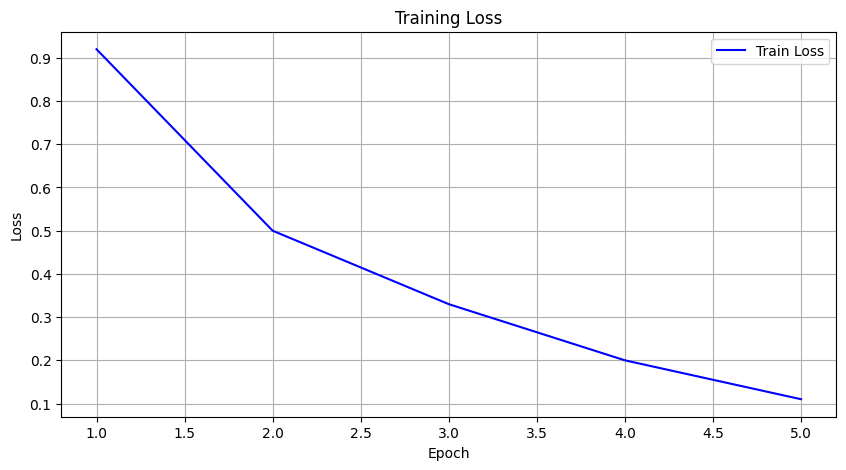

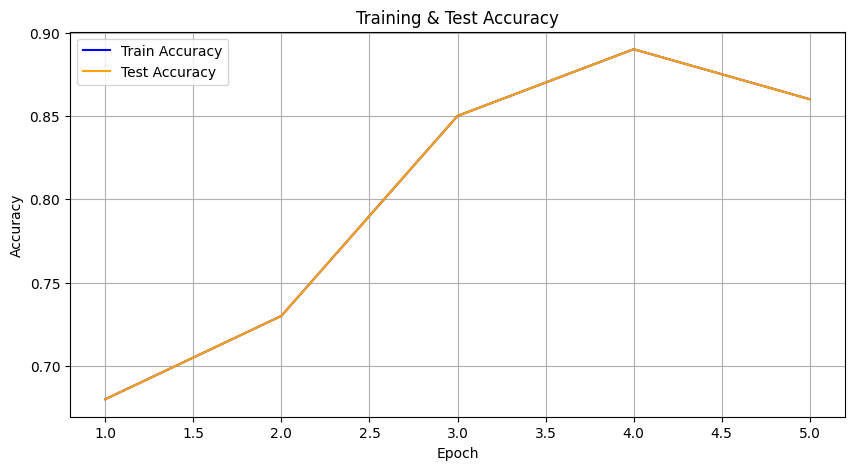

In [41]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(history['loss']) + 1), history['loss'], label='Train Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot test accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(history['accuracy']) + 1), history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'], label='Test Accuracy', color='orange')
    plt.title('Training & Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example history dictionary format:
history = {
    'loss': [0.92, 0.50, 0.33, 0.20, 0.11],
    'accuracy': [0.68, 0.73, 0.85, 0.89, 0.86],
    'val_accuracy': [0.68, 0.73, 0.85, 0.89, 0.86]
}

# Plot the training history
plot_training_history(history)
